In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

In [ ]:
# Read in all experiment results
baseline1 = pd.read_csv("./baseline1_model.csv")
baseline2 = pd.read_csv("./baseline2_model.csv")
full_model = pd.read_csv("./fullmodel_model.csv")

In [ ]:
# Merge all three datasets together
merged_results = pd.concat([baseline1, baseline2, full_model], ignore_index=True)
merged_results

,Model,ExactMatch,TokenF1,ROUGE-L,SupportRatio(avg),HallucinationRate(<0.6 support),BERTScore_P,BERTScore_R,BERTScore_F1
0,Baseline 1 (Fine-tuned only),0.0,0.346400,0.264903,0.000000,1.000000,0.658748,0.609021,0.630159
1,Baseline 2 (RAG + Base BioGPT),0.0,0.225042,0.140674,0.712412,0.194988,0.496881,0.554496,0.514206
2,Full Model (RAG + Finetuaned BioGPT),0.0,0.284330,0.184426,0.742051,0.127751,0.542817,0.620458,0.573134


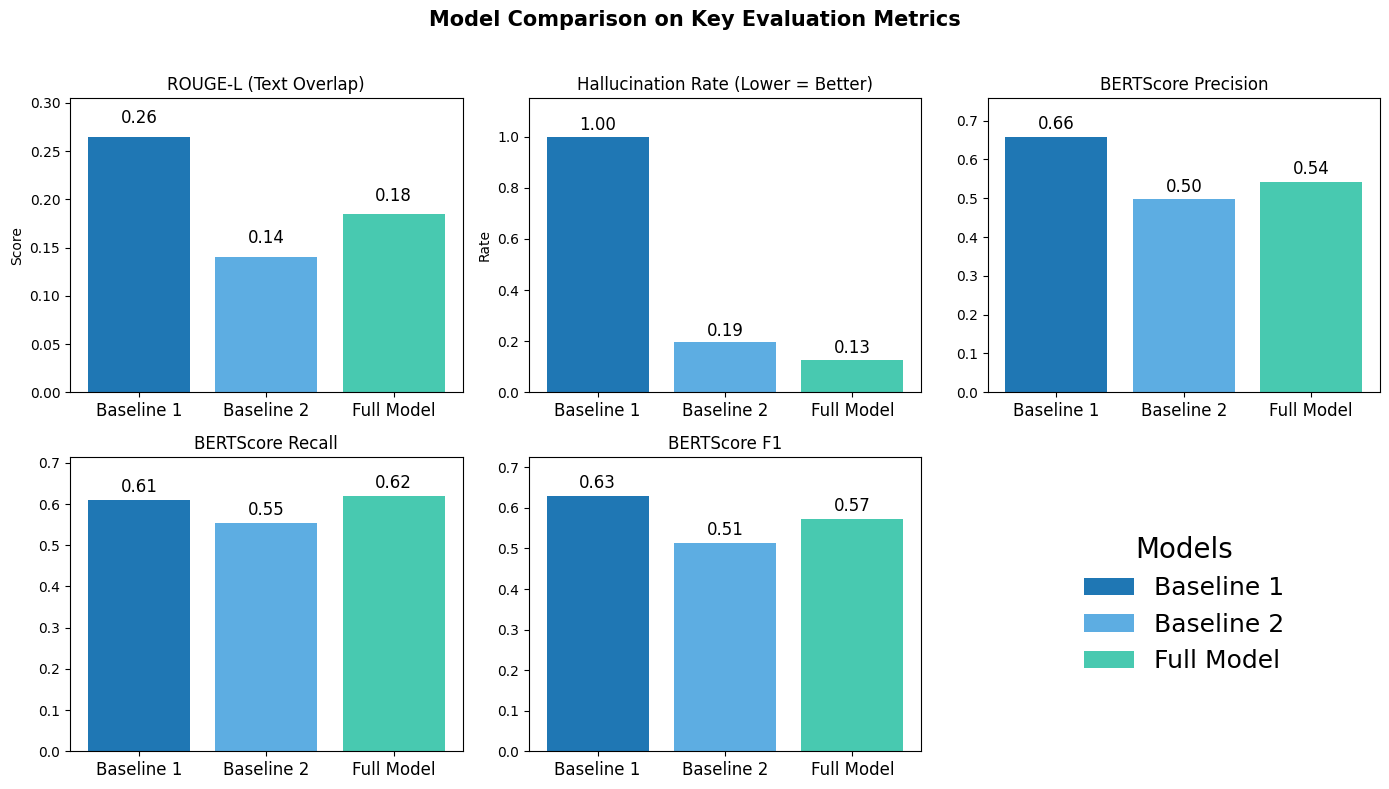

In [ ]:
# Set visual style
plt.style.use('seaborn-v0_8-deep')

# Shorter x-axis labels
short_labels = ['Baseline 1', 'Baseline 2', 'Full Model']

# Define consistent colors for all charts
color_map = ['#1f77b4', '#5dade2', '#48c9b0']  # dark blue, light blue, turquoise

# Create a 2×3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle("Model Comparison on Key Evaluation Metrics", fontsize=15, fontweight="bold")

# --- Helper function to plot each metric ---
def plot_metric(ax, values, title, ylabel=None):
    bars = ax.bar(short_labels, values, color=color_map)
    ax.set_title(title)
    if ylabel:
        ax.set_ylabel(ylabel)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
                ha='center', va='bottom', fontsize=12, fontweight='medium')
    return bars

# Plot all metrics
plot_metric(axes[0,0], merged_results["ROUGE-L"], "ROUGE-L (Text Overlap)", "Score")
plot_metric(axes[0,1], merged_results["HallucinationRate(<0.6 support)"], "Hallucination Rate (Lower = Better)", "Rate")
plot_metric(axes[0,2], merged_results["BERTScore_P"], "BERTScore Precision")
plot_metric(axes[1,0], merged_results["BERTScore_R"], "BERTScore Recall")
plot_metric(axes[1,1], merged_results["BERTScore_F1"], "BERTScore F1")

# Leave last subplot blank for legend / note
axes[1,2].axis("off")

# Create custom legend handles
legend_handles = [
    Patch(facecolor='#1f77b4', label='Baseline 1'),
    Patch(facecolor='#5dade2', label='Baseline 2'),
    Patch(facecolor='#48c9b0', label='Full Model')
]

# Add overall legend to the last subplot
axes[1,2].legend(
    handles=legend_handles,
    loc='center',
    title="Models",
    title_fontsize=20,
    fontsize=18,
    frameon=False
)

# Format axes
for ax in axes.flat[:-1]:  # skip last blank subplot
    ax.set_xticks(range(len(short_labels)))
    ax.set_xticklabels(short_labels, fontsize=12)
    ax.margins(y=0.15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

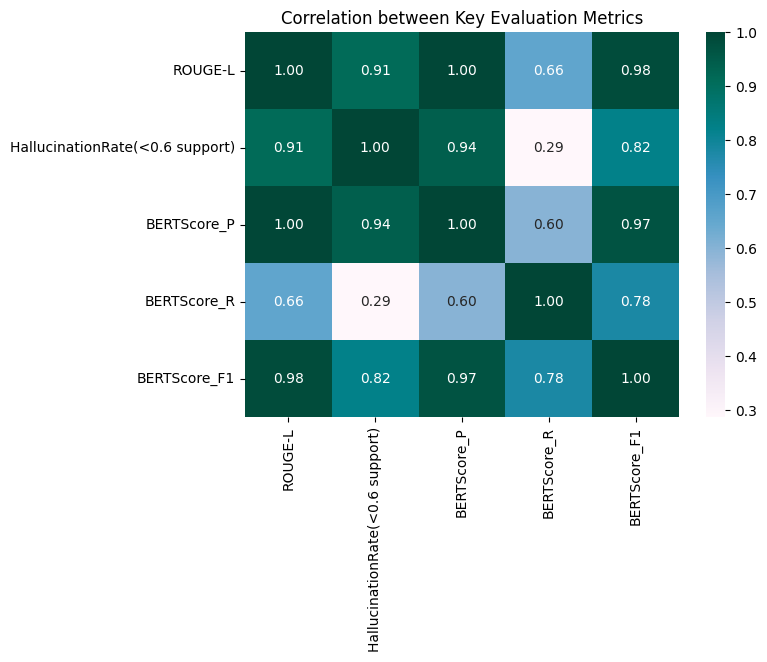

In [ ]:

metrics = ["ROUGE-L", "HallucinationRate(<0.6 support)",
            "BERTScore_P", "BERTScore_R", "BERTScore_F1"]

plt.figure(figsize=(7,5))
sns.heatmap(merged_results[metrics].corr(), annot=True, cmap="PuBuGn", fmt=".2f")
plt.title("Correlation between Key Evaluation Metrics")
plt.show()


# Key Findings:


1.   ROUGE-L and Hallucination Rate (0.91)


*  They are strongly correlated -  models that acheive higher ROUGE-L (text overlap) tend to also have higher hallucination rates.

*   This means when a model's answer sounds more similar to the gold answer, it may also be making unsupported statements. This could be observed at Baseline 1 where it imitates reference phrasing welll, but provides answers without grounded evidence.


2.   BERTScore Precision and Hallucination Rate (0.94)

*  They are highly correlated, when models have higher semantic precision (produces content closer in meaning to the reference), they also hallucinate more.

*   Indicates that purely similarity-based metrics (ROUGE, BERTScore Precision) might reward surface-level matching, even if the facts are incorrect.


3.   BERTScore Recall and Hallucination Rate (0.29)

*  They have a weak correlation. Recall (how much of the gold meaning was captured) does not vary much with hallucination.

*   Recall depends more on completeness of content rather than correctness. The model can include all relevant ideas without necessarily hallucinating.

# What this suggests:


*   This supports our findings that retrieval improves factual safety, even if it lowers superficial similarity metrics.


# Human Evaluation Results

In [ ]:
sheet_id = '1FxqApEpCk6Elr6RRxzs0vP4fA5X4RbBPVW4HOhvyW78'
sheet_name = 'human_eval_results'
url =  f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

human_df = pd.read_csv(url)
human_df.head()

,Model,Accuracy,Completeness,Clarity,Safety,Consistency,Relevance,Overall Score
0,Baseline 1,2.4,2.4,4.0,2.8,3.5,3.4,3.1
1,Baseline 2,3.2,2.9,3.0,4.0,2.4,2.8,3.0
2,Full Model,3.1,3.0,4.1,3.4,3.8,3.8,3.5


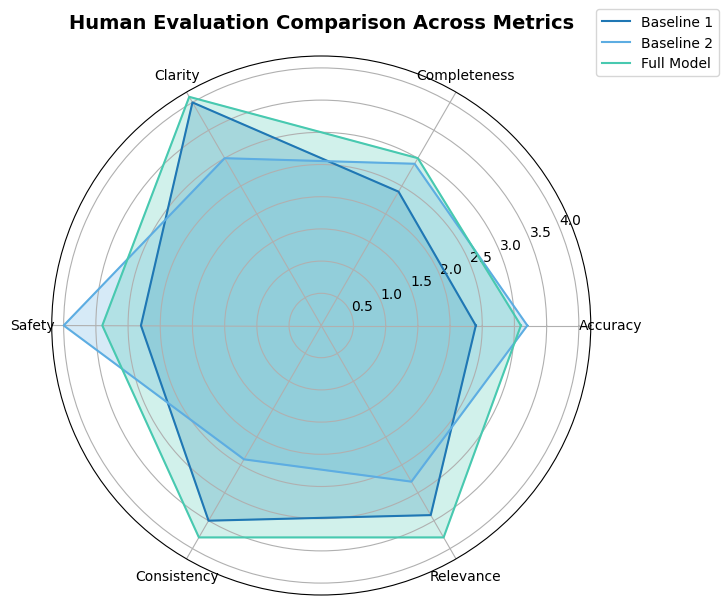

In [ ]:
# Radar chart setup
categories = ['Accuracy', 'Completeness', 'Clarity', 'Safety', 'Consistency', 'Relevance']
N = len(categories)

values1 = human_df.loc[0, categories].tolist()
values2 = human_df.loc[1, categories].tolist()
values3 = human_df.loc[2, categories].tolist()

# Repeat first value to close the polygon
values1 += values1[:1]; values2 += values2[:1]; values3 += values3[:1]
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories)

ax.plot(angles, values1, label='Baseline 1', color='#1f77b4')
ax.fill(angles, values1, alpha=0.25, color='#1f77b4')

ax.plot(angles, values2, label='Baseline 2', color='#5dade2')
ax.fill(angles, values2, alpha=0.25, color='#5dade2')

ax.plot(angles, values3, label='Full Model', color='#48c9b0')
ax.fill(angles, values3, alpha=0.25, color='#48c9b0')

plt.title("Human Evaluation Comparison Across Metrics", size=14, weight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
plt.show()


# Observations:
This is a radar chart comparing the three models across six human evaluation metrics. Each axis represents one evaluation dimension - accuracy, completeness, clarity, safety, consistency, and relevance. A larger area indicates better overall performance.

*   The Full Model (RAG + Fine-tuned BioGPT) forms the most balanced and outward-spreading shape, showing consistently strong scores across all metrics. It performs much better than the other models in consistency, relevance and clarity. This suggests that combining retrieval with domain-specific fine-tuning produces answers that are both fluent and contextually aligned with user queries.

*   Baseline 1 (Fine-tuned BioGPT only) demonstrates relatively high clarity, but it scored the lowest for accuracy, safety and completeness. This reflects how fine-tuning alone improves language quality but cannot guarantee factual correctness without retrieval support.

*   Baseine 2 (RAG + Zero-shot BioGPT) shows high safety and accuracy due to evidence grounding. However, it has the lowest consistency, relevance and clarity scores as the generator was not fine-tuned for the medical domain.

*   Overall, the radar plot highlights that the Full Model acheives the best trade-off between factual reliability and linguistic quality, while each baseline reveals specific strengths and weaknesses of its component approach.




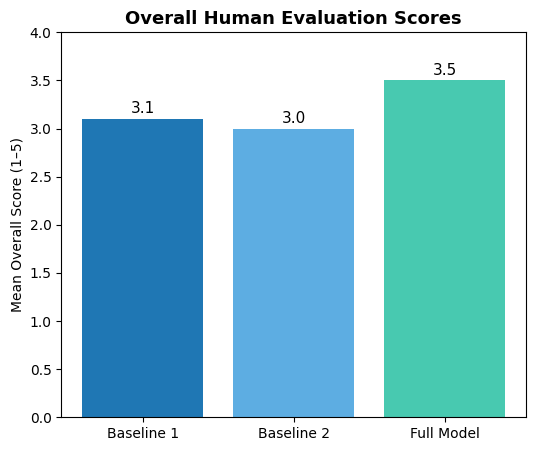

In [ ]:
plt.figure(figsize=(6,5))
bars = plt.bar(
    human_df["Model"],
    human_df["Overall Score"],
    color=["#1f77b4", "#5dade2", "#48c9b0"]
)

plt.title("Overall Human Evaluation Scores", fontweight='bold', fontsize=13)
plt.ylabel("Mean Overall Score (1–5)")

# Label bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # X position (center of bar)
        height + 0.03,                     # Y position slightly above bar
        f"{height:.1f}",                   # Label value (1 decimal)
        ha='center', va='bottom', fontsize=11, fontweight='medium'
    )

plt.ylim(0, max(human_df["Overall Score"]) + 0.5)  # Add space on top for labels
plt.show()


# Bar Plot of Overall Human Evaluation Results

## Observations



*   Full Model has the highest overall human evaluation score of 3.5. Baseline 2 has the lowest score of 3.0, reflecting that retrieval alone improved factual grounding but did not enhance linguistic quality or completeness. Meanwhile, Baseline 1 scored slightly higher than Baseline 2 (3.1), showing that fine-tuning helps with fluency and clarity but lacks factual grounding, which leads to Baseline 1 giving confident but unreliable answers.

*   This pattern reinforces that combining retrieval with domain fine-tuning leads to a more balanced and reliable model, producing answers that are not only factually accurate but also fluent and contextually appropriate.


